In [1]:
from scipy.io import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
import tensorflow as tf
print('Tensorflow version', tf.__version__)

%matplotlib inline
matplotlib.style.use("ggplot")

Tensorflow version 1.1.0


<ol>
<li><a href="#Loading-and-Formatting-Data">Loading and Formatting Data</a></li>
<li><a href="#Defining-Helper-Functions">Defining Helper Functions</a></li>
<li><a href="#Test-Model">Test Model</a></li>
</ol>

# Loading and Formatting Data

In [7]:
synth_data = loadmat('./fabricated_mnist_data/data_and_labels.mat')
all_x = synth_data['data']
all_y = synth_data['labels']
print("X shape", all_x.shape)
print("Y 'shape'", all_y.shape)
print("Y first example shape", all_y[0, 0].shape)
print("Y last example shape", all_y[0, -1].shape)

X shape (23330, 28, 140)
Y 'shape' (1, 23330)
Y first example shape (1, 10)
Y last example shape (5, 10)


Reshape y by padding < 5 length labels, and getting the length of the labels

In [8]:
all_y = all_y.reshape(-1)
all_y_lens = np.array([len(y_ex) for y_ex in all_y])
def pad(y_ex):
    toreturn = np.zeros((5, 10))
    toreturn[:len(y_ex), :] = y_ex
    return toreturn
pad(np.arange(10*2).reshape(2, 10))


array([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
       [ 10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [9]:
all_y = np.array([pad(y_ex) for y_ex in all_y])
all_y.shape

(23330, 5, 10)

One-hot encode the lengths of the sequences

In [10]:
def one_hot(num):
    num = np.ravel(num).astype(int)
    toreturn = np.zeros(shape=(len(num), 5), dtype=np.int16)
    for i, dig in enumerate(num):
        toreturn[i, dig-1] = 1
    return toreturn    
all_y_lens = one_hot(all_y_lens)

Define train-test-validation split and reshape the data to explicitly have channel size 1

In [11]:
all_x.shape

(23330, 28, 140)

In [12]:
np.random.seed(999)
idx = np.arange(len(all_x))
np.random.shuffle(idx)
temp = len(all_x)//5

train_idx = idx[:(temp*3)]
valid_idx = idx[(temp*3):(temp*4)]
test_idx = idx[(temp*4):]

train_x = all_x[train_idx].reshape(-1, 28, 140, 1)
train_y = all_y[train_idx]
train_ylen = all_y_lens[train_idx]

valid_x = all_x[valid_idx].reshape(-1, 28, 140, 1)
valid_y = all_y[valid_idx]
valid_ylen = all_y_lens[valid_idx]

test_x = all_x[test_idx].reshape(-1, 28, 140, 1)
test_y = all_y[test_idx]
test_ylen = all_y_lens[test_idx]

# Defining Helper Functions

In [67]:
def masked_xe(output, target):
    """Compute the average cross entropy of sequences up to the lengths of the targets.
    
    This assumes a target is of shape [N, L, K], where N is the number of examples, L is the maximum 
    sequence length, and K is the number of classes. Additionally, target should be zero-padded to
    arrive at the max sequence length for all sequences
    
    Borrowed from https://danijar.com/variable-sequence-lengths-in-tensorflow/.
    """
    
    cross_entropy = target * tf.log(output)
    cross_entropy = -tf.reduce_sum(cross_entropy, reduction_indices=2)
    mask = tf.sign(tf.reduce_max(tf.abs(target), reduction_indices=2))
    cross_entropy *= mask
    
    cross_entropy = tf.reduce_sum(cross_entropy, reduction_indices=1)
    cross_entropy /= tf.reduce_sum(mask, reduction_indices=1)
    return cross_entropy

In [68]:
def get_pred(len_proba, dig_proba):
    
    length = np.argmax(len_proba, axis=-1)
    digits = np.argmax(dig_proba, axis=-1)
    
    return [''.join([str(x) for x in dig[:ilen+1]]) for ilen, dig in zip(length, digits)]
lens = [
    [0, 1]+[0]*3
]
digs = [
    [
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
    ]
]
get_pred(lens, digs)

['12']

In [69]:
lens = [
    [0, 1]+[0]*3,
    [0, 0, 0, 1]+[0]
]
digs = [
    [
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
    ],
    [
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
    ]
]

In [70]:
plens = [
    [0, 1]+[0]*3,
    [0, 0, 1]+[0]*2
]
pdigs = [
    [
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
    ],
    [
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
    ]
]

In [71]:
get_pred(lens, digs)

['12', '1212']

In [72]:
get_pred(plens, pdigs)

['12', '121']

In [73]:
def accuracy(y_true, y_len_true, y_pred, y_len_pred):
    actual = np.array(get_pred(y_len_true, y_true))
    pred = np.array(get_pred(y_len_pred, y_pred))
    return np.mean(actual == pred)
accuracy(digs, lens, pdigs, plens)

0.5

# Test Model

In [146]:
lr = 0.001
len_balance = 0.8  # give the sequence length loss len_balance weight and the sequence digits loss (1-len_balance) weight 
simplest_graph =  tf.Graph()

In [168]:
with simplest_graph.as_default(): 
    tf_x = tf.placeholder(tf.float32, (None, all_x.shape[1], all_x.shape[2], 1))
    tf_y = tf.placeholder(tf.float32, (None, all_y.shape[1], all_y.shape[2]))
    tf_ylen = tf.placeholder(tf.int32, (None, 5))
    
    # (N, 28, 140, 1)
    conv1_w = tf.Variable(tf.truncated_normal(shape=[5, 5, 1, 5], stddev=0.1, seed=54), name="conv1_w")
    conv1_b = tf.Variable(tf.zeros(shape=[5]), name="conv1_b")
    
    # (N, 28, 140, 5)
    conv2_w = tf.Variable(tf.truncated_normal(shape=[1, 1, 5, 5], stddev=0.1, seed=741), name="conv2_w")
    conv2_b = tf.Variable(tf.zeros(shape=[5]), name="conv2_b")
    
    # (N, 28, 140, 5)
    
    
    # (N, 15, 71, 5)
    conv4_w = tf.Variable(tf.truncated_normal(shape=[3, 3, 5, 15], stddev=0.1, seed=11), name="conv4_w")
    conv4_b = tf.Variable(tf.zeros(shape=[15]), name="conv4_b")
    
    # (N, 15, 71, 15)
    conv5_w = tf.Variable(tf.truncated_normal(shape=[1, 1, 15, 7], stddev=0.1, seed=11), name="conv5_w")
    conv5_b = tf.Variable(tf.zeros(shape=[7]), name="conv5_b")
    
    # (N, 15, 71, 7)
        
    # (N, 8, 36, 7)
    conv7_w = tf.Variable(tf.truncated_normal(shape=[2, 4, 7, 4], stddev=0.1, seed=11), name="conv7_w")
    conv7_b = tf.Variable(tf.zeros(shape=[4]), name="conv7_b")
    
    
    # (N, 8, 36, 4) -> (N, 1410)
    dens8_w = tf.Variable(tf.truncated_normal(shape=[980, 400], stddev=0.1, seed=65), name="dens8_w")
    dens8_b = tf.Variable(tf.zeros(shape=[400]), name="dens8_b")
    
    # (N, 200)
    len_w = tf.Variable(tf.truncated_normal(shape=[400, 5], stddev=0.1, seed=76), name="len_w")
    len_b = tf.Variable(tf.zeros(shape=[5]), name="len_b")
    
    # (N, 200)
    dig_w = tf.Variable(tf.truncated_normal(shape=[400, 5*10], stddev=0.1, seed=87), name="dig_w")
    dig_b = tf.Variable(tf.zeros(shape=[5*10]), name="dig_b")

In [169]:
def model(x):
    o1 = tf.nn.relu(tf.nn.conv2d(x, conv1_w, [1, 1, 1, 1], 'SAME') + conv1_b)
    o2 = tf.nn.relu(tf.nn.conv2d(o1, conv2_w, [1, 1, 1, 1], 'SAME') + conv2_b)
    o3 = tf.nn.max_pool(o2, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    o4 = tf.nn.relu(tf.nn.conv2d(o3, conv4_w, [1, 1, 1, 1], 'SAME') + conv4_b)
    o5 = tf.nn.relu(tf.nn.conv2d(o4, conv5_w, [1, 1, 1, 1], 'SAME') + conv5_b)
    o6 = tf.nn.max_pool(o5, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    o7 = tf.nn.relu(tf.nn.conv2d(o6, conv7_w, [1, 1, 1, 1], 'SAME') + conv7_b)
    
    o7resh = tf.reshape(o7, [-1, 980])
    o8 = tf.nn.relu(tf.matmul(o7resh, dens8_w) + dens8_b)
    return o8

In [173]:
with simplest_graph.as_default():
    
    hrep = model(tf_x)
    tf_lenlogit = tf.matmul(hrep, len_w) + len_b
    tf_lenproba = tf.nn.softmax(tf_lenlogit)
    tf_diglogit = tf.reshape(tf.matmul(hrep, dig_w) + dig_b, [-1, 5, 10])
    tf_digproba = tf.nn.softmax(tf_diglogit, dim=-1)
    
    
    tf_len_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_ylen, logits=tf_lenlogit))
    mask = tf.sign(tf.reduce_max(tf.abs(tf_y), reduction_indices=2))
    mask = tf.cast(mask, tf.bool)
    tf_dig_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            labels=tf.boolean_mask(tf_y, mask),
            logits=tf.boolean_mask(tf_diglogit, mask)
        )
    )
    
#     cross_entropy = -tf.reduce_sum(tf_y * tf.log(tf_digproba), reduction_indices=2)
#     mask = tf.sign(tf.reduce_max(tf.abs(tf_y), reduction_indices=2))
#     masked_cross_entropy = cross_entropy * mask
    
#     mean_masked_xe = tf.reduce_sum(masked_cross_entropy, reduction_indices=1)
#     mean_masked_xe /= tf.reduce_sum(mask, reduction_indices=1)

#     tf_dig_loss = tf.reduce_mean(masked_xe(tf_digproba, tf_y))
    
    
    
    optimizer = tf.train.AdamOptimizer(lr)
    updater = optimizer.minimize(tf_len_loss*len_balance + tf_dig_loss*(1-len_balance))

/home/ian/miniconda3/envs/dl-env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [210]:
n_epochs = 30
batch_size = 20
steps_per_epoch = 2500
compare_every = 30
t_len_losses, v_len_losses = [], []
t_dig_losses, v_dig_losses = [], []
t_acc, v_acc = [], []

In [211]:
def capture_performance():
    global session
    global batch_size
    global batch_idx
    global train_x
    global train_y
    global train_ylen
    global valid_x
    global valid_y
    global valid_ylen
    global t_acc
    global v_acc
#     print('Saving performance')
    
    train_len_loss, train_dig_loss, train_len_proba, train_dig_proba = session.run([tf_len_loss, tf_dig_loss, 
                                                                                    tf_lenproba, tf_digproba], 
                                                                                   feed_dict={
        tf_x: train_x[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
        tf_y: train_y[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
        tf_ylen: train_ylen[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)]        
    })
    
    valid_len_loss, valid_dig_loss, valid_len_proba, valid_dig_proba = session.run([tf_len_loss, tf_dig_loss, 
                                                                                    tf_lenproba, tf_digproba], 
                                                                                   feed_dict={
        tf_x: valid_x, tf_y: valid_y, tf_ylen: valid_ylen})
    
    t_len_losses.append(np.mean(train_len_loss))
    t_dig_losses.append(np.mean(train_dig_loss))
    t_acc.append(accuracy(train_y[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
                          train_ylen[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)],
                          train_dig_proba,
                          train_len_proba))
    v_len_losses.append(np.mean(valid_len_loss))
    v_dig_losses.append(np.mean(valid_dig_loss))
    v_acc.append(accuracy(valid_y, valid_ylen, valid_dig_proba, valid_len_proba))                      

/home/ian/miniconda3/envs/dl-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ian/miniconda3/envs/dl-env/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 0
Validation accuracy 40.699%
Mean batch len loss 0.047
Valid len loss 0.014
Mean batch dig loss 1.478
Valid dig loss 0.866


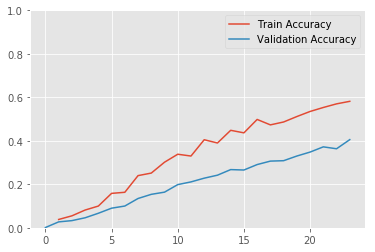

Epoch 1
Validation accuracy 58.808%
Mean batch len loss 0.005
Valid len loss 0.009
Mean batch dig loss 0.578
Valid dig loss 0.532


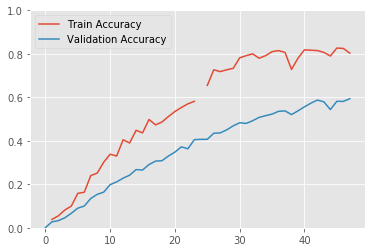

Epoch 2
Validation accuracy 67.938%
Mean batch len loss 0.002
Valid len loss 0.005
Mean batch dig loss 0.328
Valid dig loss 0.386


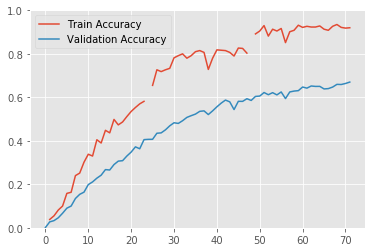

Epoch 3
Validation accuracy 67.252%
Mean batch len loss 0.002
Valid len loss 0.013
Mean batch dig loss 0.219
Valid dig loss 0.420


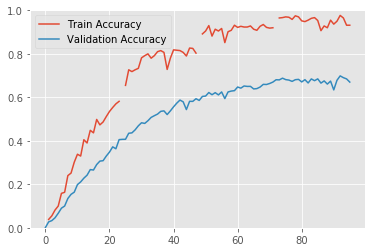

Epoch 4
Validation accuracy 69.846%
Mean batch len loss 0.002
Valid len loss 0.008
Mean batch dig loss 0.157
Valid dig loss 0.396


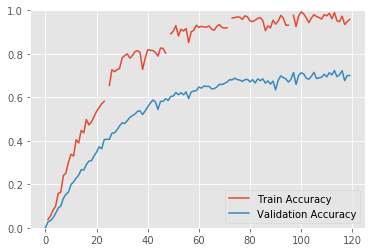

Epoch 5
Validation accuracy 72.996%
Mean batch len loss 0.002
Valid len loss 0.009
Mean batch dig loss 0.120
Valid dig loss 0.372


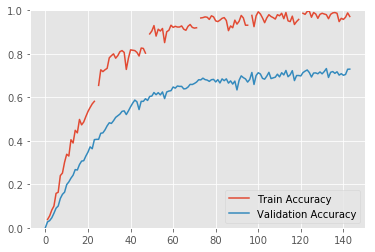

Epoch 6
Validation accuracy 72.075%
Mean batch len loss 0.000
Valid len loss 0.008
Mean batch dig loss 0.082
Valid dig loss 0.439


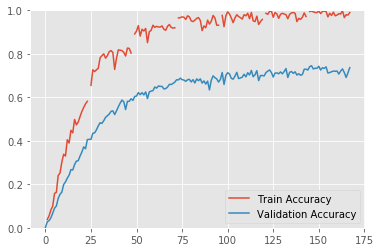

Epoch 7
Validation accuracy 71.560%
Mean batch len loss 0.000
Valid len loss 0.009
Mean batch dig loss 0.069
Valid dig loss 0.459


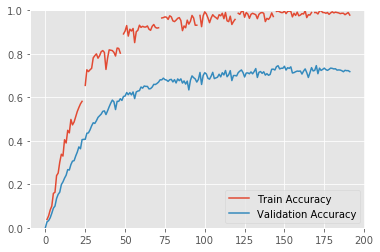

Epoch 8
Validation accuracy 73.082%
Mean batch len loss 0.001
Valid len loss 0.009
Mean batch dig loss 0.071
Valid dig loss 0.415


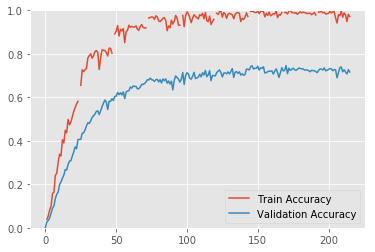

Epoch 9
Validation accuracy 72.310%
Mean batch len loss 0.001
Valid len loss 0.020
Mean batch dig loss 0.069
Valid dig loss 0.406


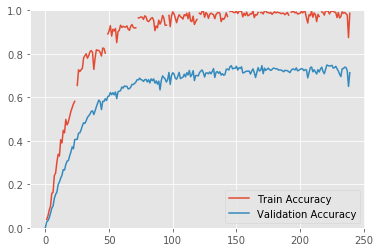

Epoch 10
Validation accuracy 74.411%
Mean batch len loss 0.004
Valid len loss 0.013
Mean batch dig loss 0.075
Valid dig loss 0.409


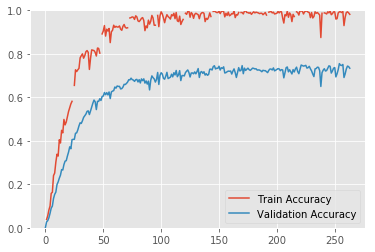

Epoch 11
Validation accuracy 74.989%
Mean batch len loss 0.002
Valid len loss 0.007
Mean batch dig loss 0.042
Valid dig loss 0.466


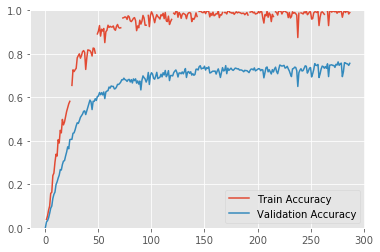

Epoch 12
Validation accuracy 74.346%
Mean batch len loss 0.000
Valid len loss 0.008
Mean batch dig loss 0.027
Valid dig loss 0.482


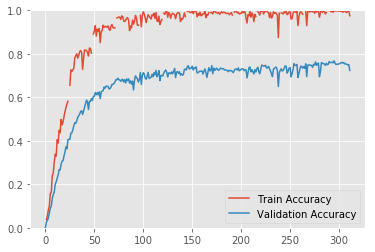

Epoch 13
Validation accuracy 75.654%
Mean batch len loss 0.001
Valid len loss 0.008
Mean batch dig loss 0.055
Valid dig loss 0.423


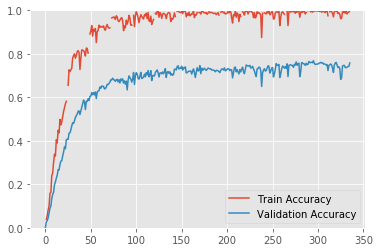

Epoch 14
Validation accuracy 70.982%
Mean batch len loss 0.000
Valid len loss 0.007
Mean batch dig loss 0.029
Valid dig loss 0.519


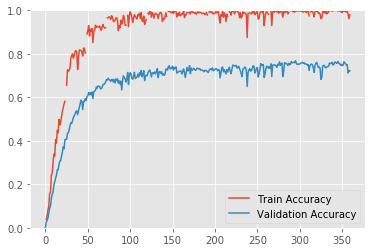

Epoch 15
Validation accuracy 75.761%
Mean batch len loss 0.000
Valid len loss 0.007
Mean batch dig loss 0.037
Valid dig loss 0.439


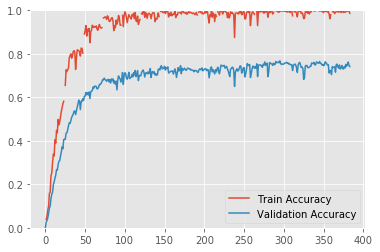

Epoch 16
Validation accuracy 73.339%
Mean batch len loss 0.001
Valid len loss 0.012
Mean batch dig loss 0.038
Valid dig loss 0.572


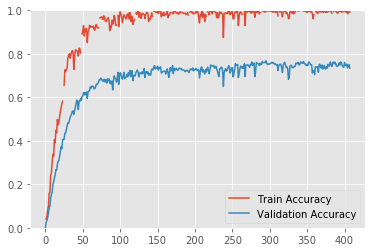

KeyboardInterrupt: 

In [212]:
session = tf.InteractiveSession(graph=simplest_graph)
init = tf.global_variables_initializer()
init.run()
np.random.seed(123456)
for ep in range(n_epochs):
    idx = np.arange(len(train_x))
    np.random.shuffle(idx) # shuffling the data each epoch
    train_x = train_x[idx]
    train_y = train_y[idx]
    train_ylen = train_ylen[idx]
    ep_len_losses = []
    ep_dig_losses = []
    for batch_idx in range(min(len(train_x)//batch_size, steps_per_epoch)):
        batch_x = train_x[batch_size*batch_idx:(batch_size*(batch_idx+1))].reshape(-1, 28, 140, 1)
        batch_y = train_y[batch_size*batch_idx:(batch_size*(batch_idx+1))]
        batch_ylen = train_ylen[batch_size*batch_idx:(batch_size*(batch_idx+1))]
#         _,  batch_len_loss, batch_dig_loss, batch_mean_masked_xe, batch_mask, batch_masked_xe, batch_cross_entropy, batch_dig_proba = \
#                 session.run([updater, tf_len_loss, tf_dig_loss, mean_masked_xe, mask, masked_cross_entropy, cross_entropy, tf_digproba], 
#                                                          feed_dict={tf_x: batch_x, tf_y: batch_y, tf_ylen: batch_ylen})
        _,  batch_len_loss, batch_dig_loss = session.run([updater, tf_len_loss, tf_dig_loss], 
                                                         feed_dict={tf_x: batch_x, tf_y: batch_y, tf_ylen: batch_ylen})
        ep_len_losses.append(np.mean(batch_len_loss))
        ep_dig_losses.append(np.mean(batch_dig_loss))
        if (batch_idx) % compare_every == 0:
            capture_performance()        
        
    v_len_loss, v_dig_loss, v_len_proba, v_dig_proba = session.run([tf_len_loss, tf_dig_loss, tf_lenproba, tf_digproba], 
                                                                {tf_x: valid_x, tf_y: valid_y, tf_ylen: valid_ylen})
    print("Epoch {}".format(ep))
#     print(v_acc)
    print("Validation accuracy {:<2.3%}".format(accuracy(valid_y, valid_ylen, v_dig_proba, v_len_proba)))
          
    print("Mean batch len loss {:<2.3f}".format(np.mean(ep_len_losses)))
    print("Valid len loss {:<2.3f}".format(np.mean(v_len_loss)))
    
    print("Mean batch dig loss {:<2.3f}".format(np.mean(ep_dig_losses)))
    print("Valid dig loss {:<2.3f}".format(np.mean(v_dig_loss)))
    
    plt.plot(t_acc, label='Train Accuracy')
    plt.plot(v_acc, label='Validation Accuracy')
    plt.ylim((0, 1))
    plt.legend()
    plt.show()

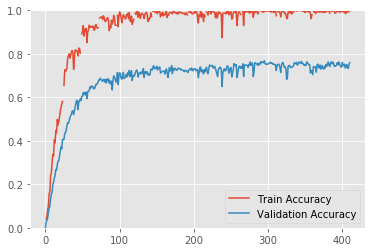

In [213]:
plt.plot(t_acc, label='Train Accuracy')
plt.plot(v_acc, label='Validation Accuracy')
plt.ylim((0, 1))
plt.legend()
plt.show()

## Adding some regularization

In [235]:
def model(x, p):
    o1 = tf.nn.relu(tf.nn.conv2d(x, conv1_w, [1, 1, 1, 1], 'SAME') + conv1_b)
#     o1 = tf.nn.dropout(o1, p)
    o2 = tf.nn.relu(tf.nn.conv2d(o1, conv2_w, [1, 1, 1, 1], 'SAME') + conv2_b)
    o3 = tf.nn.max_pool(o2, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    o4 = tf.nn.relu(tf.nn.conv2d(o3, conv4_w, [1, 1, 1, 1], 'SAME') + conv4_b)
#     o4 = tf.nn.dropout(o4, p)
    o5 = tf.nn.relu(tf.nn.conv2d(o4, conv5_w, [1, 1, 1, 1], 'SAME') + conv5_b)
    o6 = tf.nn.max_pool(o5, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    o7 = tf.nn.relu(tf.nn.conv2d(o6, conv7_w, [1, 1, 1, 1], 'SAME') + conv7_b)
    
    o7resh = tf.reshape(o7, [-1, 980])
    o8 = tf.nn.relu(tf.matmul(o7resh, dens8_w) + dens8_b)
    o8 = tf.nn.dropout(o8, p)
    return o8

In [239]:
with simplest_graph.as_default():
    p = tf.placeholder_with_default(1.0, shape=())
    hrep = model(tf_x, p)
    tf_lenlogit = tf.matmul(hrep, len_w) + len_b
    tf_lenproba = tf.nn.softmax(tf_lenlogit)
    tf_diglogit = tf.reshape(tf.matmul(hrep, dig_w) + dig_b, [-1, 5, 10])
    tf_digproba = tf.nn.softmax(tf_diglogit, dim=-1)
    
    
    tf_len_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_ylen, logits=tf_lenlogit))
    mask = tf.sign(tf.reduce_max(tf.abs(tf_y), reduction_indices=2))
    mask = tf.cast(mask, tf.bool)
    tf_dig_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            labels=tf.boolean_mask(tf_y, mask),
            logits=tf.boolean_mask(tf_diglogit, mask)
        )
    )
    
    optimizer = tf.train.AdamOptimizer(lr)
    updater = optimizer.minimize(tf_len_loss*len_balance + tf_dig_loss*(1-len_balance) + 
                                 tf.nn.l2_loss(dens8_w)*0.003 + 
                                 tf.nn.l2_loss(len_w)*0.001 + 
                                 tf.nn.l2_loss(dig_w)*0.001)

/home/ian/miniconda3/envs/dl-env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [240]:
n_epochs = 30
batch_size = 20
steps_per_epoch = 250000
compare_every = 60
t_len_losses, v_len_losses = [], []
t_dig_losses, v_dig_losses = [], []
t_acc, v_acc = [], []

/home/ian/miniconda3/envs/dl-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ian/miniconda3/envs/dl-env/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 0
Validation accuracy 27.840%
Mean batch len loss 0.059
Valid len loss 0.020
Mean batch dig loss 1.849
Valid dig loss 1.198


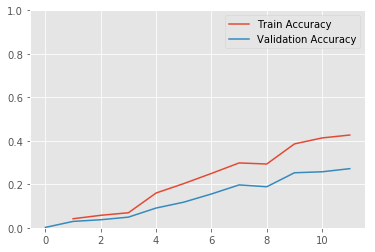

Epoch 1
Validation accuracy 43.013%
Mean batch len loss 0.019
Valid len loss 0.012
Mean batch dig loss 1.076
Valid dig loss 0.811


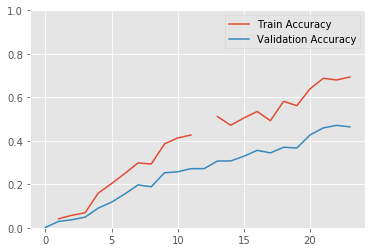

Epoch 2
Validation accuracy 54.865%
Mean batch len loss 0.016
Valid len loss 0.011
Mean batch dig loss 0.820
Valid dig loss 0.585


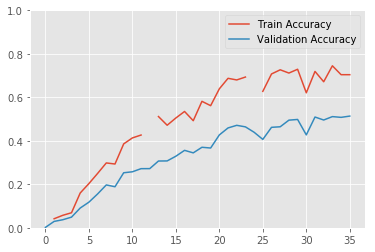

Epoch 3
Validation accuracy 59.837%
Mean batch len loss 0.018
Valid len loss 0.007
Mean batch dig loss 0.704
Valid dig loss 0.531


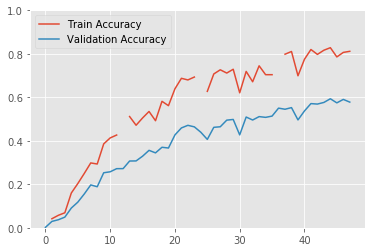

Epoch 4
Validation accuracy 65.195%
Mean batch len loss 0.008
Valid len loss 0.007
Mean batch dig loss 0.609
Valid dig loss 0.444


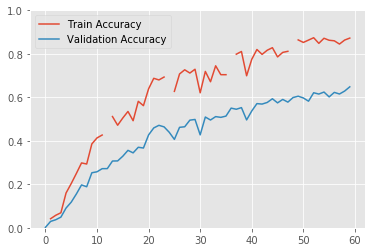

Epoch 5
Validation accuracy 63.223%
Mean batch len loss 0.012
Valid len loss 0.021
Mean batch dig loss 0.551
Valid dig loss 0.460


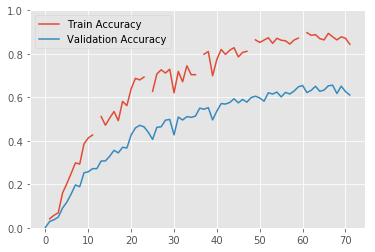

Epoch 6
Validation accuracy 67.917%
Mean batch len loss 0.011
Valid len loss 0.014
Mean batch dig loss 0.541
Valid dig loss 0.399


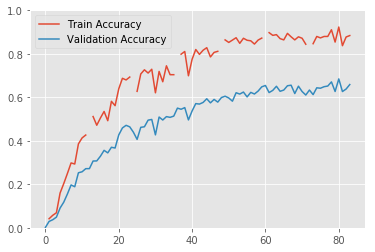

Epoch 7
Validation accuracy 69.781%
Mean batch len loss 0.017
Valid len loss 0.009
Mean batch dig loss 0.527
Valid dig loss 0.381


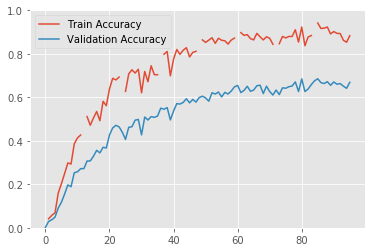

Epoch 8
Validation accuracy 69.481%
Mean batch len loss 0.017
Valid len loss 0.004
Mean batch dig loss 0.488
Valid dig loss 0.370


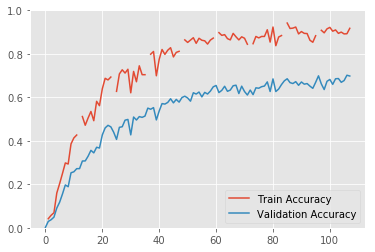

Epoch 9
Validation accuracy 68.045%
Mean batch len loss 0.013
Valid len loss 0.022
Mean batch dig loss 0.480
Valid dig loss 0.393


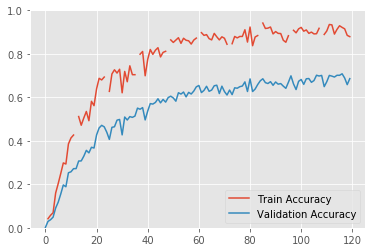

Epoch 10
Validation accuracy 72.739%
Mean batch len loss 0.010
Valid len loss 0.009
Mean batch dig loss 0.465
Valid dig loss 0.336


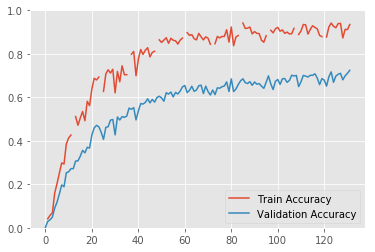

Epoch 11
Validation accuracy 69.010%
Mean batch len loss 0.014
Valid len loss 0.007
Mean batch dig loss 0.459
Valid dig loss 0.409


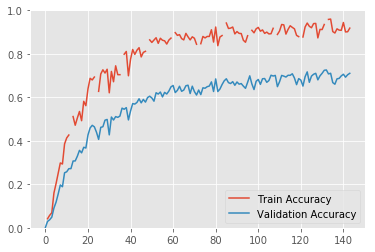

Epoch 12
Validation accuracy 74.518%
Mean batch len loss 0.011
Valid len loss 0.006
Mean batch dig loss 0.443
Valid dig loss 0.312


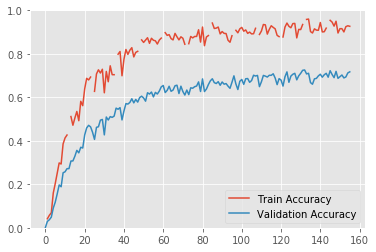

Epoch 13
Validation accuracy 73.511%
Mean batch len loss 0.013
Valid len loss 0.013
Mean batch dig loss 0.434
Valid dig loss 0.339


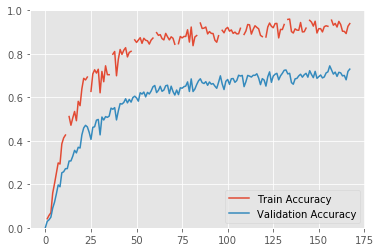

Epoch 14
Validation accuracy 72.696%
Mean batch len loss 0.013
Valid len loss 0.016
Mean batch dig loss 0.424
Valid dig loss 0.329


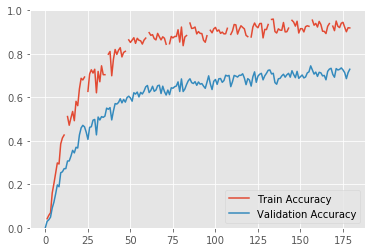

Epoch 15
Validation accuracy 69.610%
Mean batch len loss 0.010
Valid len loss 0.009
Mean batch dig loss 0.413
Valid dig loss 0.378


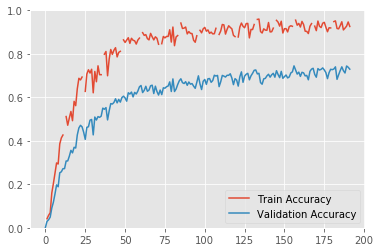

Epoch 16
Validation accuracy 75.182%
Mean batch len loss 0.014
Valid len loss 0.006
Mean batch dig loss 0.424
Valid dig loss 0.307


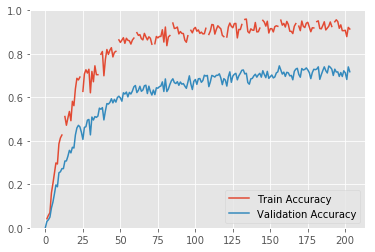

Epoch 17
Validation accuracy 71.196%
Mean batch len loss 0.011
Valid len loss 0.005
Mean batch dig loss 0.396
Valid dig loss 0.361


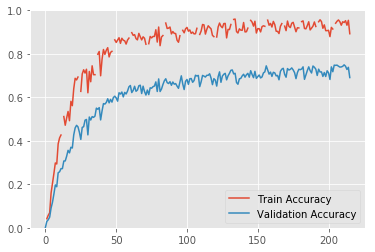

In [ ]:
session = tf.InteractiveSession(graph=simplest_graph)
init = tf.global_variables_initializer()
init.run()
np.random.seed(123456)
for ep in range(n_epochs):
    idx = np.arange(len(train_x))
    np.random.shuffle(idx) # shuffling the data each epoch
    train_x = train_x[idx]
    train_y = train_y[idx]
    train_ylen = train_ylen[idx]
    ep_len_losses = []
    ep_dig_losses = []
    for batch_idx in range(min(len(train_x)//batch_size, steps_per_epoch)):
        batch_x = train_x[batch_size*batch_idx:(batch_size*(batch_idx+1))].reshape(-1, 28, 140, 1)
        batch_y = train_y[batch_size*batch_idx:(batch_size*(batch_idx+1))]
        batch_ylen = train_ylen[batch_size*batch_idx:(batch_size*(batch_idx+1))]
#         _,  batch_len_loss, batch_dig_loss, batch_mean_masked_xe, batch_mask, batch_masked_xe, batch_cross_entropy, batch_dig_proba = \
#                 session.run([updater, tf_len_loss, tf_dig_loss, mean_masked_xe, mask, masked_cross_entropy, cross_entropy, tf_digproba], 
#                                                          feed_dict={tf_x: batch_x, tf_y: batch_y, tf_ylen: batch_ylen})
        _,  batch_len_loss, batch_dig_loss = session.run([updater, tf_len_loss, tf_dig_loss], 
                                                         feed_dict={tf_x: batch_x, tf_y: batch_y,
                                                                    tf_ylen: batch_ylen, p: 0.75})
        ep_len_losses.append(np.mean(batch_len_loss))
        ep_dig_losses.append(np.mean(batch_dig_loss))
        if (batch_idx) % compare_every == 0:
            capture_performance()        
        
    v_len_loss, v_dig_loss, v_len_proba, v_dig_proba = session.run([tf_len_loss, tf_dig_loss, tf_lenproba, tf_digproba], 
                                                                {tf_x: valid_x, tf_y: valid_y, tf_ylen: valid_ylen})
    print("Epoch {}".format(ep))
#     print(v_acc)
    print("Validation accuracy {:<2.3%}".format(accuracy(valid_y, valid_ylen, v_dig_proba, v_len_proba)))
          
    print("Mean batch len loss {:<2.3f}".format(np.mean(ep_len_losses)))
    print("Valid len loss {:<2.3f}".format(np.mean(v_len_loss)))
    
    print("Mean batch dig loss {:<2.3f}".format(np.mean(ep_dig_losses)))
    print("Valid dig loss {:<2.3f}".format(np.mean(v_dig_loss)))
    
    plt.plot(t_acc, label='Train Accuracy')
    plt.plot(v_acc, label='Validation Accuracy')
    plt.ylim((0, 1))
    plt.legend()
    plt.show()

In [ ]:
plt.plot(t_acc, label='Train Accuracy')
plt.plot(v_acc, label='Validation Accuracy')
plt.ylim((0, 1))
plt.legend()
plt.show()

Trying a different weight between length and digit prediction

In [ ]:
len_balance = 0.5

In [ ]:
with simplest_graph.as_default():
    p = tf.placeholder_with_default(1.0, shape=())
    hrep = model(tf_x, p)
    tf_lenlogit = tf.matmul(hrep, len_w) + len_b
    tf_lenproba = tf.nn.softmax(tf_lenlogit)
    tf_diglogit = tf.reshape(tf.matmul(hrep, dig_w) + dig_b, [-1, 5, 10])
    tf_digproba = tf.nn.softmax(tf_diglogit, dim=-1)
    
    
    tf_len_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_ylen, logits=tf_lenlogit))
    mask = tf.sign(tf.reduce_max(tf.abs(tf_y), reduction_indices=2))
    mask = tf.cast(mask, tf.bool)
    tf_dig_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            labels=tf.boolean_mask(tf_y, mask),
            logits=tf.boolean_mask(tf_diglogit, mask)
        )
    )
    
    optimizer = tf.train.AdamOptimizer(lr)
    updater = optimizer.minimize(tf_len_loss*len_balance + tf_dig_loss*(1-len_balance) + 
                                 tf.nn.l2_loss(dens8_w)*0.003 + 
                                 tf.nn.l2_loss(len_w)*0.001 + 
                                 tf.nn.l2_loss(dig_w)*0.001)

In [ ]:
n_epochs = 30
batch_size = 20
steps_per_epoch = 250000
compare_every = 60
t_len_losses, v_len_losses = [], []
t_dig_losses, v_dig_losses = [], []
t_acc, v_acc = [], []

In [ ]:
session = tf.InteractiveSession(graph=simplest_graph)
init = tf.global_variables_initializer()
init.run()
np.random.seed(123456)
for ep in range(n_epochs):
    idx = np.arange(len(train_x))
    np.random.shuffle(idx) # shuffling the data each epoch
    train_x = train_x[idx]
    train_y = train_y[idx]
    train_ylen = train_ylen[idx]
    ep_len_losses = []
    ep_dig_losses = []
    for batch_idx in range(min(len(train_x)//batch_size, steps_per_epoch)):
        batch_x = train_x[batch_size*batch_idx:(batch_size*(batch_idx+1))].reshape(-1, 28, 140, 1)
        batch_y = train_y[batch_size*batch_idx:(batch_size*(batch_idx+1))]
        batch_ylen = train_ylen[batch_size*batch_idx:(batch_size*(batch_idx+1))]
#         _,  batch_len_loss, batch_dig_loss, batch_mean_masked_xe, batch_mask, batch_masked_xe, batch_cross_entropy, batch_dig_proba = \
#                 session.run([updater, tf_len_loss, tf_dig_loss, mean_masked_xe, mask, masked_cross_entropy, cross_entropy, tf_digproba], 
#                                                          feed_dict={tf_x: batch_x, tf_y: batch_y, tf_ylen: batch_ylen})
        _,  batch_len_loss, batch_dig_loss = session.run([updater, tf_len_loss, tf_dig_loss], 
                                                         feed_dict={tf_x: batch_x, tf_y: batch_y,
                                                                    tf_ylen: batch_ylen, p: 0.75})
        ep_len_losses.append(np.mean(batch_len_loss))
        ep_dig_losses.append(np.mean(batch_dig_loss))
        if (batch_idx) % compare_every == 0:
            capture_performance()        
        
    v_len_loss, v_dig_loss, v_len_proba, v_dig_proba = session.run([tf_len_loss, tf_dig_loss, tf_lenproba, tf_digproba], 
                                                                {tf_x: valid_x, tf_y: valid_y, tf_ylen: valid_ylen})
    print("Epoch {}".format(ep))
#     print(v_acc)
    print("Validation accuracy {:<2.3%}".format(accuracy(valid_y, valid_ylen, v_dig_proba, v_len_proba)))
          
    print("Mean batch len loss {:<2.3f}".format(np.mean(ep_len_losses)))
    print("Valid len loss {:<2.3f}".format(np.mean(v_len_loss)))
    
    print("Mean batch dig loss {:<2.3f}".format(np.mean(ep_dig_losses)))
    print("Valid dig loss {:<2.3f}".format(np.mean(v_dig_loss)))
    
    plt.plot(t_acc, label='Train Accuracy')
    plt.plot(v_acc, label='Validation Accuracy')
    plt.ylim((0, 1))
    plt.legend()
    plt.show()

Trying out different optimizer/learning rate

In [ ]:
lr = 0.01
len_balance = 0.5

In [ ]:
with simplest_graph.as_default():
    p = tf.placeholder_with_default(1.0, shape=())
    hrep = model(tf_x, p)
    tf_lenlogit = tf.matmul(hrep, len_w) + len_b
    tf_lenproba = tf.nn.softmax(tf_lenlogit)
    tf_diglogit = tf.reshape(tf.matmul(hrep, dig_w) + dig_b, [-1, 5, 10])
    tf_digproba = tf.nn.softmax(tf_diglogit, dim=-1)
    
    
    tf_len_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_ylen, logits=tf_lenlogit))
    mask = tf.sign(tf.reduce_max(tf.abs(tf_y), reduction_indices=2))
    mask = tf.cast(mask, tf.bool)
    tf_dig_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            labels=tf.boolean_mask(tf_y, mask),
            logits=tf.boolean_mask(tf_diglogit, mask)
        )
    )
    
    optimizer = tf.train.MomentumOptimizer(lr, 0.9)
    updater = optimizer.minimize(tf_len_loss*len_balance + tf_dig_loss*(1-len_balance) + 
                                 tf.nn.l2_loss(dens8_w)*0.003 + 
                                 tf.nn.l2_loss(len_w)*0.001 + 
                                 tf.nn.l2_loss(dig_w)*0.001)

In [ ]:
n_epochs = 30
batch_size = 20
steps_per_epoch = 250000
compare_every = 60
t_len_losses, v_len_losses = [], []
t_dig_losses, v_dig_losses = [], []
t_acc, v_acc = [], []

In [ ]:
session = tf.InteractiveSession(graph=simplest_graph)
init = tf.global_variables_initializer()
init.run()
np.random.seed(123456)
for ep in range(n_epochs):
    idx = np.arange(len(train_x))
    np.random.shuffle(idx) # shuffling the data each epoch
    train_x = train_x[idx]
    train_y = train_y[idx]
    train_ylen = train_ylen[idx]
    ep_len_losses = []
    ep_dig_losses = []
    for batch_idx in range(min(len(train_x)//batch_size, steps_per_epoch)):
        batch_x = train_x[batch_size*batch_idx:(batch_size*(batch_idx+1))].reshape(-1, 28, 140, 1)
        batch_y = train_y[batch_size*batch_idx:(batch_size*(batch_idx+1))]
        batch_ylen = train_ylen[batch_size*batch_idx:(batch_size*(batch_idx+1))]
#         _,  batch_len_loss, batch_dig_loss, batch_mean_masked_xe, batch_mask, batch_masked_xe, batch_cross_entropy, batch_dig_proba = \
#                 session.run([updater, tf_len_loss, tf_dig_loss, mean_masked_xe, mask, masked_cross_entropy, cross_entropy, tf_digproba], 
#                                                          feed_dict={tf_x: batch_x, tf_y: batch_y, tf_ylen: batch_ylen})
        _,  batch_len_loss, batch_dig_loss = session.run([updater, tf_len_loss, tf_dig_loss], 
                                                         feed_dict={tf_x: batch_x, tf_y: batch_y,
                                                                    tf_ylen: batch_ylen, p: 0.75})
        ep_len_losses.append(np.mean(batch_len_loss))
        ep_dig_losses.append(np.mean(batch_dig_loss))
        if (batch_idx) % compare_every == 0:
            capture_performance()        
        
    v_len_loss, v_dig_loss, v_len_proba, v_dig_proba = session.run([tf_len_loss, tf_dig_loss, tf_lenproba, tf_digproba], 
                                                                {tf_x: valid_x, tf_y: valid_y, tf_ylen: valid_ylen})
    print("Epoch {}".format(ep))
#     print(v_acc)
    print("Validation accuracy {:<2.3%}".format(accuracy(valid_y, valid_ylen, v_dig_proba, v_len_proba)))
          
    print("Mean batch len loss {:<2.3f}".format(np.mean(ep_len_losses)))
    print("Valid len loss {:<2.3f}".format(np.mean(v_len_loss)))
    
    print("Mean batch dig loss {:<2.3f}".format(np.mean(ep_dig_losses)))
    print("Valid dig loss {:<2.3f}".format(np.mean(v_dig_loss)))
    
    plt.plot(t_acc, label='Train Accuracy')
    plt.plot(v_acc, label='Validation Accuracy')
    plt.ylim((0, 1))
    plt.legend()
    plt.show()

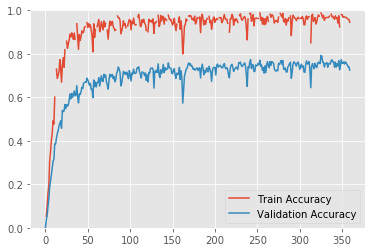

In [222]:
plt.plot(t_acc, label='Train Accuracy')
plt.plot(v_acc, label='Validation Accuracy')
plt.ylim((0, 1))
plt.legend()
plt.show()